In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
from scipy.spatial import ConvexHull
import meshio
import scipy
from pygsp.graphs import Graph
import healpy as hp
from pyevtk.hl import unstructuredGridToVTK
from pyevtk.vtk import VtkTriangle, VtkQuad
import pyshtools
import pdb


optimal_sigmas = {
    1:1,
    2:0.3,
    4:0.175,
    8:0.0525,
    16:0.015,
    32:0.002
}


class MyGraph(Graph):
    
    def __init__(self, W, coords):
        super(MyGraph, self).__init__(W=W, coords=coords)
        

    
    def _init_vtk(self):
        from pyevtk.vtk import VtkTriangle, VtkQuad
        tri = ConvexHull(self.coords)
        self.simplices = tri.simplices
        self.conn = self.simplices.flatten()
        self.offset = np.arange(3,len(self.conn)+1, 3)
        self.ctype = np.ones(len(self.offset))*VtkTriangle.tid


    def save_signal(self, title='unstructured', pointData=None):
        from pyevtk.hl import unstructuredGridToVTK
        if pointData is not None:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': pointData})
        else:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': self.x})
        
    def save_mesh(self, file="mesh.xml"):
        self._init_vtk()
        cells = {"triangle": self.simplices}
        meshio.write_points_cells(
            file,
            self.coords,
            cells)
        

class FullHEALPix(MyGraph):
    sigmas = optimal_sigmas
    
    def make_coords(self):
        indexes = range(self.nside**2 * 12)
        # Get the coordinates.
        x, y, z = hp.pix2vec(self.nside, indexes)  # RING (DEFAULT) ordered
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords)
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        return coords

    
    def __init__(self, nside=8, std=None):
        self.nside = nside
        self.npix = 12*nside**2
        coords = self.make_coords()
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        if isinstance(std, float) or isinstance(std, int):
            W = np.exp(-distances_squared / std)
        else:
            W = np.exp(-distances_squared / self.sigmas[nside])
        W = W-np.diag(np.diag(W))
        super(FullHEALPix, self).__init__(W=W, coords=coords)
        self._init_vtk()


plt.rcParams['figure.figsize'] = (17, 5)  
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
       }

In [121]:
def alm_getidx(lmax, l, m):
    return int(m*(2*lmax+1-m)/2+l)

def alm2spectrum(alm):
    n = len(alm)
    lmax = int((-1+np.sqrt(1+8*n))/2)-1
    my_spec = np.zeros(lmax+1)

    for l in range(lmax+1):
        if not l:
            my_spec[l] = np.abs(alm[0])**2
        else:
            j = alm_getidx(lmax, l, 0)
            my_spec[l] = np.abs(alm[j])**2
            for m in range(1,l+1):
                j = alm_getidx(lmax, l, m)
                my_spec[l] += 2*np.abs(alm[j])**2
        my_spec[l] /= 2*l+1
    return my_spec

def reorder_alm(alm):
    n = len(alm)
    ordered_alm = np.zeros(n, dtype=complex)
    lmax = int((-1+np.sqrt(1+8*n))/2)-1
    count = 0
    for l in range(lmax+1):
        for m in range(l+1):
            j = alm_getidx(lmax, l, m)
            ordered_alm[count] = alm[j]
            count += 1
    assert count == n, "{}, {}".format(count, n)
    return ordered_alm

def equivariance_error(hmap, L):
    # -------------- calculations -------------------
    spec, alm = hp.sphtfunc.anafast(hmap, alm=True)
    Lspec, Lalm = hp.sphtfunc.anafast(L@hmap, alm=True)
    
    my_spec = alm2spectrum(alm)
    my_Lspec = alm2spectrum(Lalm)
    
    alm_ratio = np.abs(reorder_alm(Lalm))**2/np.abs(reorder_alm(alm))**2
    
    # TODO: faire le ratio avec parties reelles et imaginaires
    
    spec_ratio = np.abs(Lspec/spec)
    relative_stddev = np.zeros(len(spec))
    stddev = np.zeros(len(spec))
    for l in range(lmax+1):
        ratio_0 = alm_ratio[l*(l+1)//2]
        positive_ratio = alm_ratio[l*(l+1)//2+1 : (l+1)*(l+2)//2]
        full_ratio = np.zeros(2*l+1)
        full_ratio[0] = ratio_0
        full_ratio[1:l+1] = positive_ratio
        full_ratio[l+1:] = positive_ratio
        stddev[l] = np.sqrt(np.var(full_ratio))
        relative_stddev[l] = stddev[l]/np.mean(full_ratio)
    
    # -------------- plotting -------------------
    """
    # spectra
    plt.plot(spec, 'b', label='original, anafast')
    plt.plot(Lspec, 'r', label='filtered, anafast')
    plt.plot(my_spec, 'bo', label='original, me')
    plt.plot(my_Lspec, 'ro', label='filtered, me')
    plt.legend()
    plt.show()
    
    """
    # a_lm ratio
    plt.plot(alm_ratio[1:], label='alm ratio')
    plt.legend()
    plt.show()
    """
    # zoom on a_lm ratio
    plt.plot(alm_ratio[1:50], 'bo', label='alm ratio')
    plt.legend()
    plt.show()
    
    # spectra ratio
    plt.plot(my_Lspec/my_spec, 'b-', label='spectrum ratio as calculated by me')
    plt.plot(Lspec/spec, 'bo', label='spectrum ratio by alm2cl in anafast')
    plt.legend()
    plt.show()
    
    # stddev of a_lm ratio
    plt.plot(stddev, label='stddev af alm_ratio by degree')
    plt.legend()
    plt.show()"""
    
    # relative stddev of a_lm ratio
    plt.plot(relative_stddev, label='relative_stddev af alm_ratio by degree')
    plt.legend()
    plt.show()

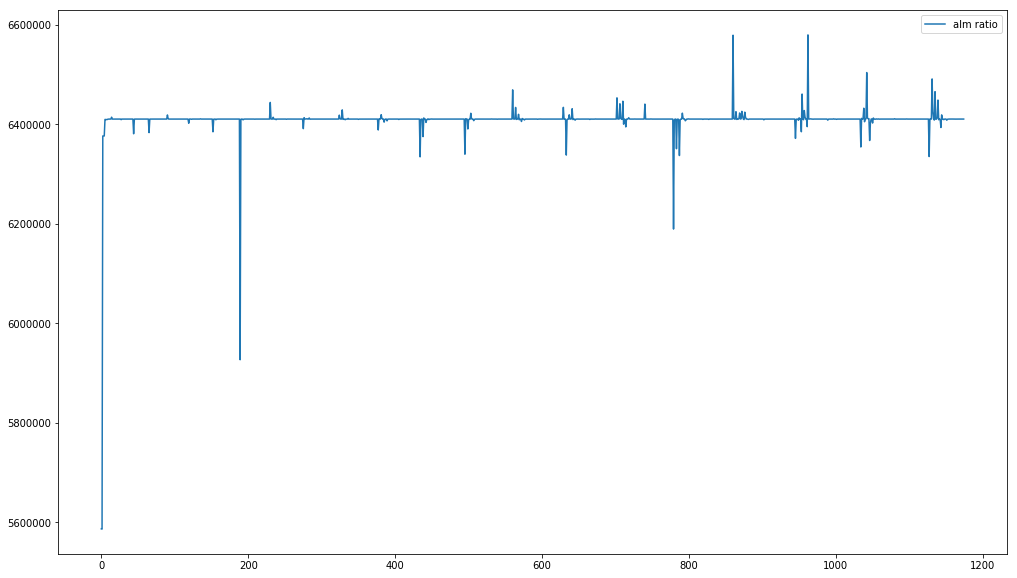

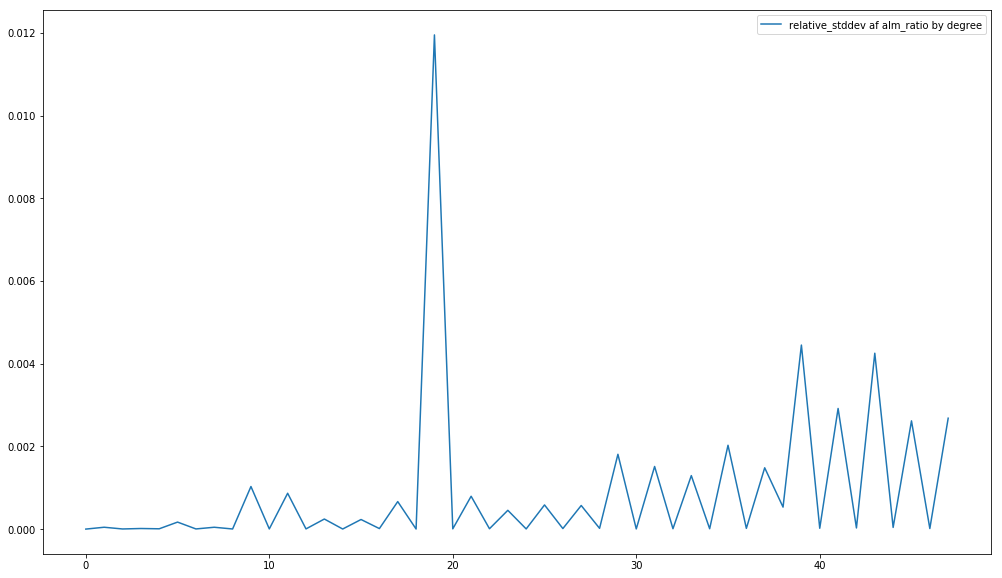

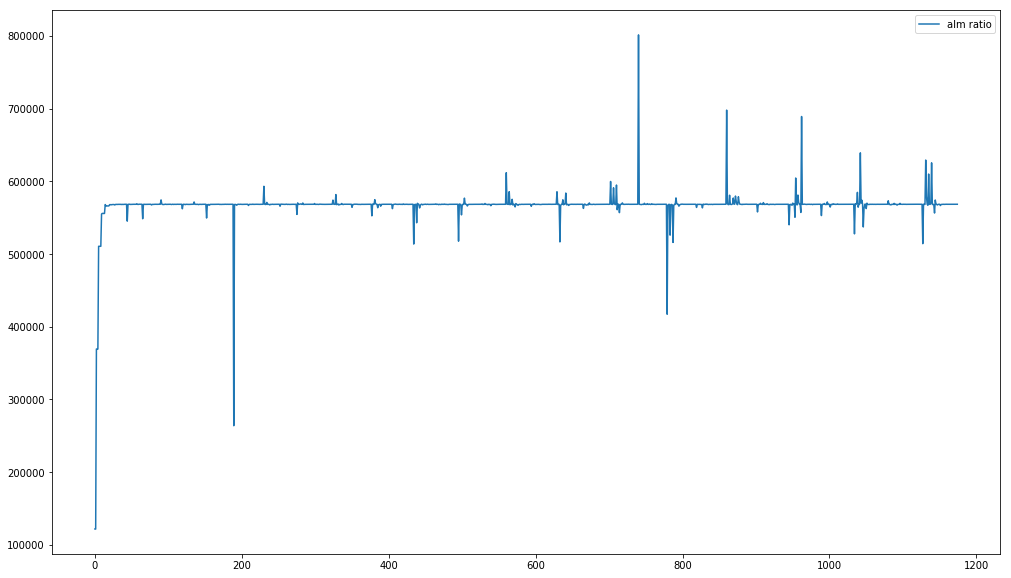

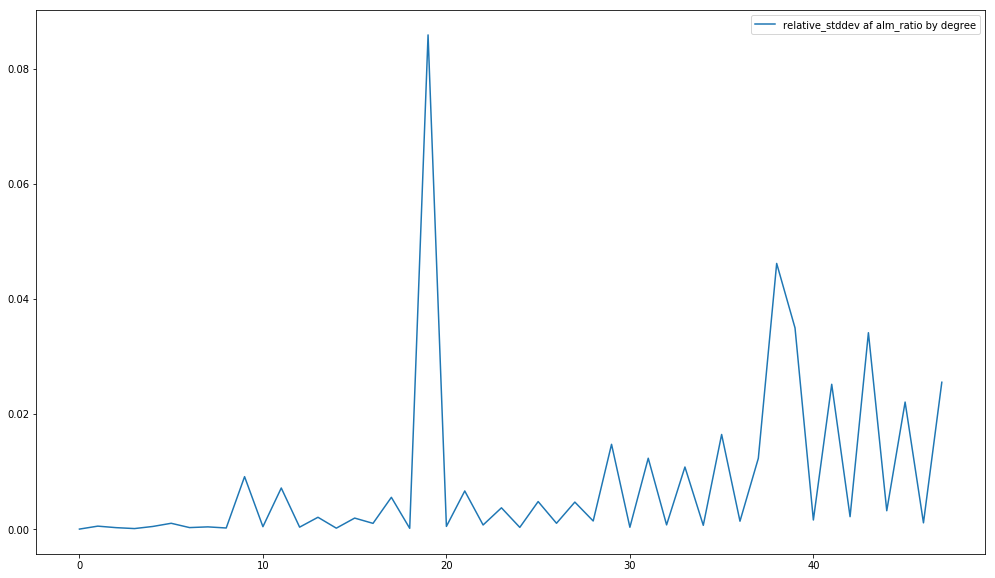

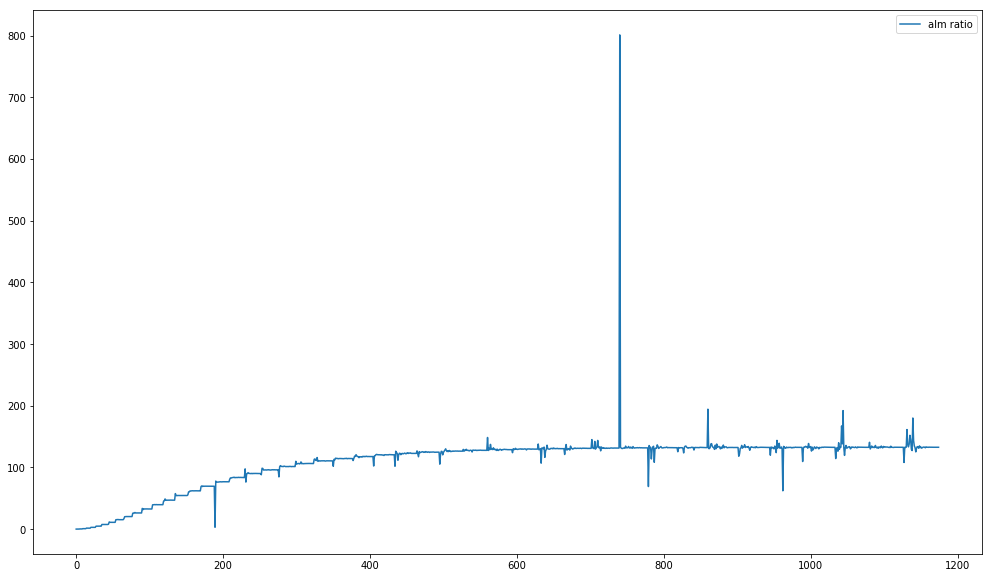

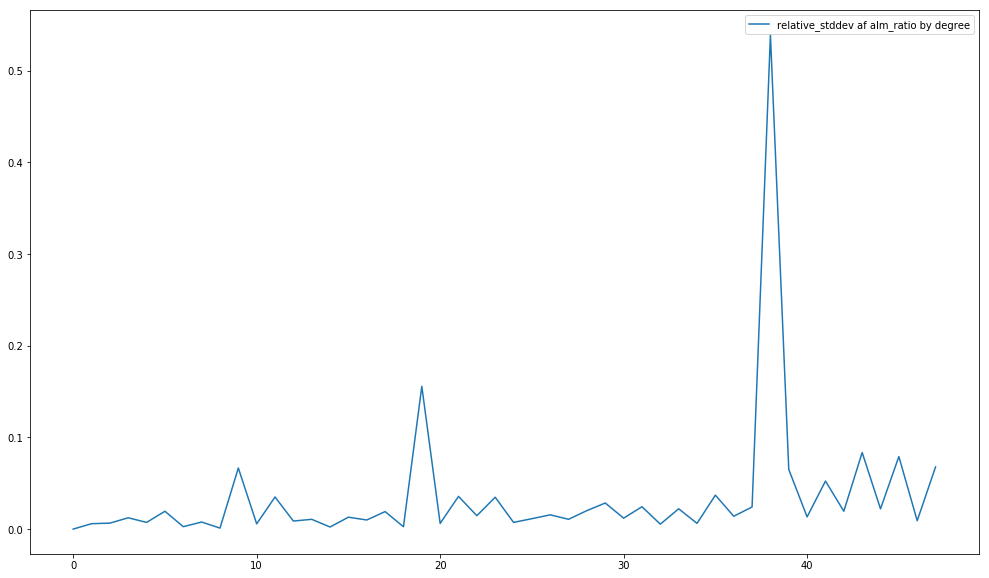

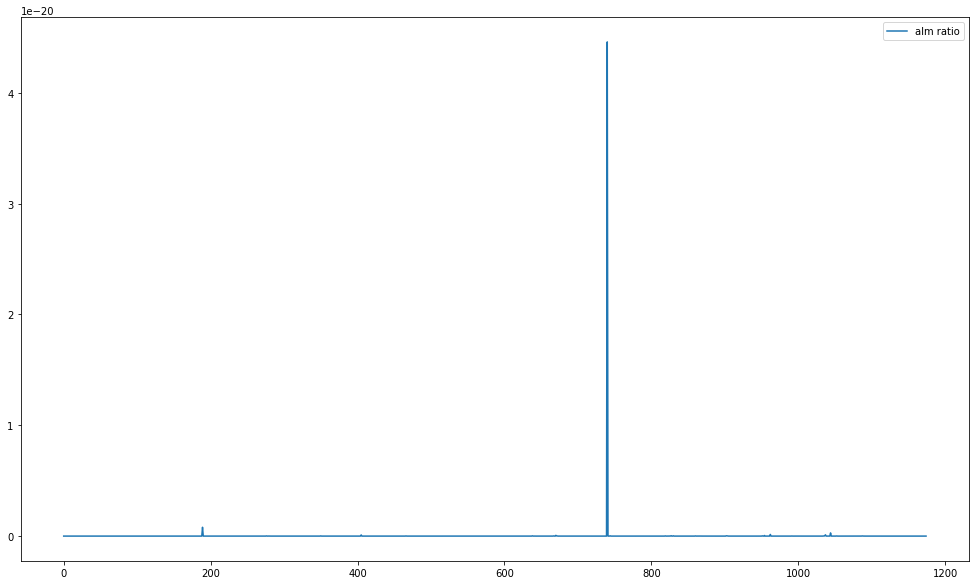

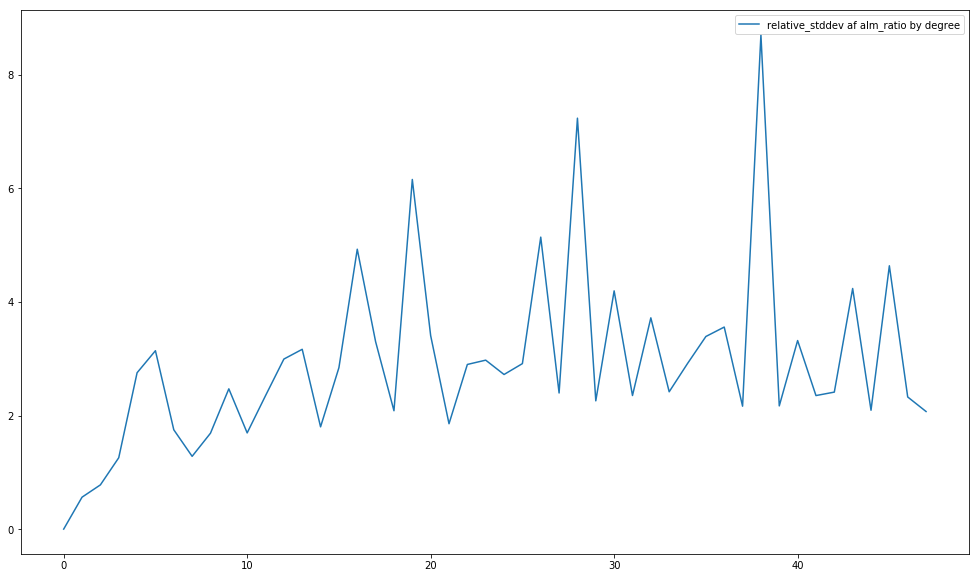

/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


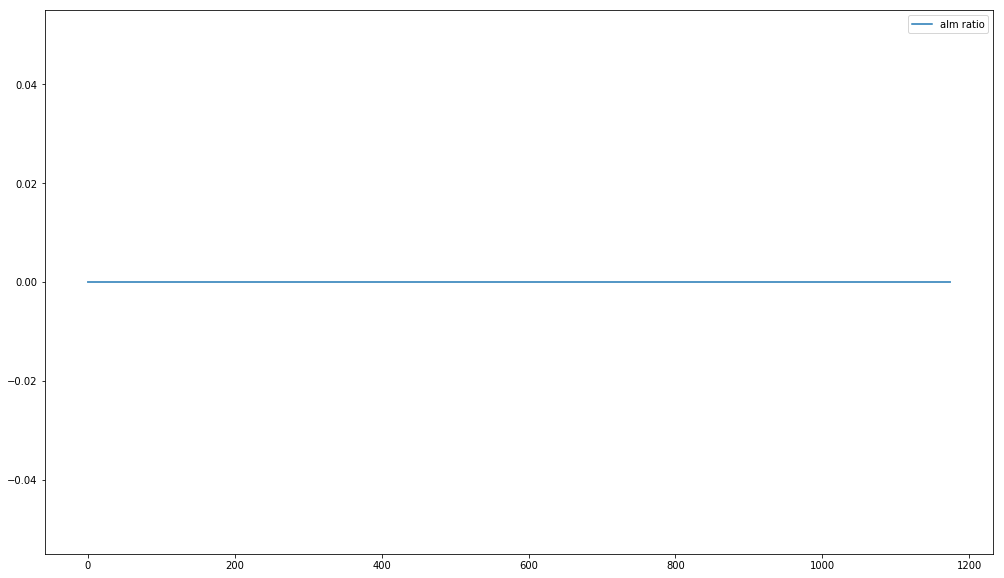

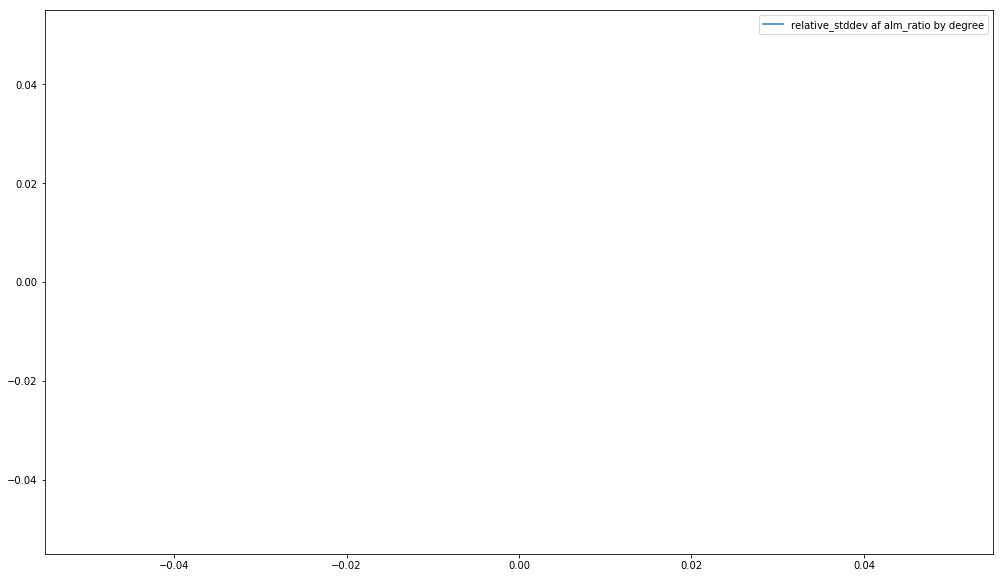

In [122]:
plt.rcParams['figure.figsize'] = (17, 10)  

sphere = FullHEALPix(16, std=10)
equivariance_error(hmap, sphere.L)

sphere = FullHEALPix(16, std=1)
equivariance_error(hmap, sphere.L)

sphere = FullHEALPix(16)
equivariance_error(hmap, sphere.L)

sphere = FullHEALPix(16, std=0.0001)
equivariance_error(hmap, sphere.L)

sphere = FullHEALPix(16, std=0.0000001)
equivariance_error(hmap, sphere.L)

### Martino's comments
* The relative standard deviation by degree of the fourier coefficients a_lm keeps growing as the kernel width decreases from 10 to 1e-4, no matter that the actual optimum we found (by measuring the alignment of the eigenvectors, as in DeepSphere) is located at 0.015. 
* we notice however that the shape of the a_lm ratio close the the optimum is very different from the others, however this doesn't give us any valuable information on where to look for the optimal kernel width.
* It seems that the only way to optimize the kernel width is the brute force approach of the alignment of the eigenvectors.
* The second way (still brute force, minimizing the equivariance error) also is tricky since for a disconnected graph the equivariance error is zero, so that would be the optimum...

My proposal is to keep optimizing the alignment of the eigenvectors. If performed on a sparse matrix already, maybe the eigen decomposition could be doable if limited to few eigenvectors even for large matrices. The steps would be 

* fix number of neighbors (idea of the epsilon graph) and optimise t with alignment of the first N (100?) eigenvectors obtained through an iterative algorithm (scipy.sparse.linalg.eigs with shift invert mode activated - parameter sigma=0 -)

However building the full graph is computationally too expensive: we need to use the function healpy.pixelfunc.get_all_neighbors() that retrieves the 8 neirest neighbors iteratively. The we calculate the weights between only these pixels while building the adjacency matrix. In this way we don't exactly have a radius graph, due to the irregular shape of the romboids of the HEALPix pixelization, but it should be someway close. we can perform a check afterwards eliminating those points who are too distant. In order to change kernel width effectively, we need to store distances in a separate matrix and use it to build the different adjacency matrices. We need to implement the optimization function (maximum degree with alignment $>=80\%$ for example) and launch a grid search, since we know nothing about eventual convexity of the function to optimize